In [2]:
import torch
print(torch.__version__)
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


2.7.1+cu118


In [3]:
# 导入必要的库
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import random

# 设置随机种子以确保结果的可复现性
torch.manual_seed(42)  # 设置 PyTorch 的随机种子
np.random.seed(42)     # 设置 NumPy 的随机种子
random.seed(42)        # 设置 Python 内置随机模块的种子
print("Torch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)



# 检测并设置设备（CPU 或 GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 打印设备信息
print("Using device:", device)

# 如果使用的是 GPU，打印 GPU 的详细信息
if device.type == "cuda":
    print("GPU Model:", torch.cuda.get_device_name(0))  # 打印 GPU 模型
    print("CUDA Version:", torch.version.cuda)          # 打印 CUDA 版本

Torch version: 2.7.1+cu118
Numpy version: 1.23.5
Pandas version: 1.5.3
Using device: cuda
GPU Model: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8


In [ ]:
"""
该脚本的主要功能是处理气象数据
包括解压数据文件、加载数据、预处理、归一化和构造时间序列样本。
具体步骤如下：
1. 解压 ZIP 文件，提取其中的 CSV 数据文件。
2. 加载 CSV 文件，读取气象数据。
3. 将日期时间列转换为 datetime 类型，便于后续处理。
4. 选择需要的气象特征列，并去除缺失值。
5. 将处理后的数据保存为新的 CSV 文件（可选）。
6. 对特征数据进行归一化处理，以便更好地训练模型。
7. 构造时间序列样本，将数据划分为输入序列 X 和目标标签 y。
8. 输出样本输入 X 和标签 y 的维度信息，确保数据格式正确。
"""
import pandas as pd
import numpy as np
import zipfile
from sklearn.preprocessing import MinMaxScaler
import os
import joblib

# 定义一个函数来处理气象数据
def preprocess_weather_data(zip_path, extract_path, features=None, sequence_length=72, target_column="T (degC)"):
    """
    处理气象数据的函数
    :param zip_path: ZIP 文件路径
    :param extract_path: 解压路径
    :param features: 需要处理的特征列，默认为 ["T (degC)", "rh (%)", "wv (m/s)"]
    :param sequence_length: 时间序列的长度，默认为 72
    :param target_column: 预测目标列，默认为 "T (degC)"
    """
    # 如果没有指定特征列，则使用默认值
    if features is None:
        features = ["T (degC)", "rh (%)", "wv (m/s)"]
    
    # ========== 1. 解压 ZIP 文件 ==========
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"文件已成功解压到 {extract_path}")
    
    # ========== 2. 加载 CSV 数据 ==========
    csv_path = os.path.join(extract_path, "jena_climate_2009_2016.csv")
    df = pd.read_csv(csv_path)
    print(f"成功加载 CSV 文件，数据行数: {len(df)}")
    
    # ========== 3. 日期转换 ==========
    df["Date Time"] = pd.to_datetime(df["Date Time"])
    
    # ========== 4. 选择特征列 ==========
    # 检查指定的特征列是否存在于数据集中
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"以下特征列不存在于数据集中: {missing_features}")
    
    df_selected = df[["Date Time"] + features].dropna()
    print(f"选择的特征列: {features}")
    
    # ========== 5. 保存为新的 CSV 文件 ==========
    df_selected.to_csv("weather.csv", index=False)
    print("处理后的数据已保存为 weather.csv")
    
    # ========== 6. 归一化处理 ==========
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_selected[features])
    joblib.dump(scaler, "scaler.pkl")
    print("归一化完成，归一化器已保存为 scaler.pkl")
    
    # 6.1 单独对目标列归一化（用于预测结果反归一化）
    y_scaler = MinMaxScaler()
    y_scaled_column = y_scaler.fit_transform(df_selected[[target_column]])
    joblib.dump(y_scaler, "y_scaler.pkl")
    print("目标列归一化器已保存为 y_scaler.pkl")
    
    # ========== 7. 构造时间序列样本 ==========
    def create_sequences(data, sequence_length, target_column_index):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length][target_column_index])
        return np.array(X), np.array(y)
    
    target_column_index = features.index(target_column)  # 获取目标列的索引
    X, y = create_sequences(data_scaled, sequence_length, target_column_index)
    
    # ========== 8. 输出维度信息 ==========
    print("样本输入 X shape:", X.shape)
    print("标签 y shape:", y.shape)
    
    # 保存处理后的数据为 .npy 文件
    np.save("X.npy", X)
    np.save("y.npy", y)
    print("处理后的数据已保存为 X.npy 和 y.npy")



# 调用函数
zip_path = "jena_climate.zip"
extract_path = "jena_climate"
preprocess_weather_data(zip_path, extract_path)我这个归一化是不是有问题

文件已成功解压到 jena_climate
成功加载 CSV 文件，数据行数: 420551
选择的特征列: ['T (degC)', 'rh (%)', 'wv (m/s)']
处理后的数据已保存为 weather.csv
归一化完成，归一化器已保存为 scaler.pkl
目标列归一化器已保存为 y_scaler.pkl
样本输入 X shape: (420479, 72, 3)
标签 y shape: (420479,)
处理后的数据已保存为 X.npy 和 y.npy


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

"""
该代码的功能是将气象数据封装为 PyTorch 数据集，并划分训练集和验证集。
主要步骤：
1. 定义一个继承自 Dataset 的 WeatherDataset 类，用于封装气象数据。
2. 创建数据集实例，并根据指定比例随机划分训练集和验证集。
3. 创建训练集和验证集的数据加载器 DataLoader 用于批量加载数据。
"""

# 定义一个天气数据集类，继承自 torch.utils.data.Dataset
class WeatherDataset(Dataset):
    """
    天气数据集类，用于封装气象数据。
    :param X: 特征数据
    :param y: 目标数据
    """
    def __init__(self, X, y):
        # 初始化函数，将输入的特征数据 X 和目标数据 y 转换为 torch 张量
        self.X = torch.tensor(X, dtype=torch.float32)  # 特征数据
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # 以确保输出形状为 (batch, 1)，方便回归模型处理

    def __len__(self):
        """
        返回数据集的长度，即样本数量。
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        根据索引 idx 获取数据集中的一个样本，返回特征和目标。
        :param idx: 样本索引
        :return: 特征和目标
        """
        return self.X[idx], self.y[idx]

def create_data_loaders(X, y, train_ratio=0.8, batch_size=32, shuffle_train=True, shuffle_val=False):
    """
    创建训练集和验证集的数据加载器。
    :param X: 特征数据
    :param y: 目标数据
    :param train_ratio: 训练集占总数据集的比例，默认为 0.8
    :param batch_size: 每个批次的样本数量，默认为 32
    :param shuffle_train: 是否打乱训练集，默认为 True
    :param shuffle_val: 是否打乱验证集，默认为 False
    :return: 训练集数据加载器和验证集数据加载器
    """
    # 创建数据集实例
    dataset = WeatherDataset(X, y)

    # 计算训练集和验证集的大小
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    # 随机划分数据集为训练集和验证集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # 创建训练集和验证集的数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)

    return train_loader, val_loader

# 示例：使用封装的函数创建数据加载器
# 假设 X 和 y 分别是特征数据和目标数据（需要提前定义）
# train_loader, val_loader = create_data_loaders(X, y)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === 参数汇总 ===
# 输入特征维度: input_dim
# 隐藏层维度: hidden_dim (默认值: 64)
# 激素模块隐藏层维度: hormone_dim (默认值: 32)
# 最大序列长度: max_seq_len (默认值: 72)
# 池化策略: pooling (默认值: "mean"，可选值: "mean", "max", "last", "attention")
# 图注意力层多头注意力头数: n_heads (默认值: 8)
# Dropout 概率: dropout (默认值: 0.1)
# Transformer 编码器前馈网络维度: dim_feedforward (默认值: hidden_dim * 4)
# Transformer 编码器层数: num_layers (默认值: 1)

In [ ]:
class GraphAttentionLayer(nn.Module):
    """
    图注意力层，用于模拟节点之间的间接影响。
    参数：
        in_dim (int): 输入特征的维度
        out_dim (int): 输出特征的维度
        n_heads (int): 多头注意力的头数，默认为 8
        dropout (float): Dropout 概率，默认为 0.1
    """
    def __init__(self, in_dim, out_dim, n_heads=8, dropout=0.1):
        super(GraphAttentionLayer, self).__init__()
        self.n_heads = n_heads  # 多头注意力的头数
        self.out_dim = out_dim  # 输出维度
        self.W = nn.Linear(in_dim, out_dim, bias=False)  # 线性变换，将输入维度映射到输出维度
        self.a = nn.Parameter(torch.empty(size=(2 * (out_dim // n_heads), 1)))  # 注意力参数矩阵
        nn.init.xavier_uniform_(self.a.data, gain=1.414)  # 使用 Xavier 初始化方法初始化注意力参数矩阵
        self.dropout = nn.Dropout(dropout)  # Dropout 层，用于防止过拟合
        
        # 如果输入维度和输出维度不一致，则使用残差投影层
        if in_dim != out_dim:
            self.residual_proj = nn.Linear(in_dim, out_dim)
        else:
            self.residual_proj = nn.Identity()

    def forward(self, x, adj_matrix=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
        返回：
            torch.Tensor: 输出特征，形状为 [B, T, out_dim]
        """
        B, T, D = x.size()  # 输入张量的形状，B 是批次大小，T 是节点数量，D 是输入特征维度
        h = self.W(x).view(B, T, self.n_heads, -1)  # 应用线性变换并调整形状
        h = h.permute(0, 2, 1, 3)  # 调整维度顺序，方便后续操作

        # 生成节点特征的重复版本，用于计算节点之间的注意力权重
        h_repeat = h.unsqueeze(3).repeat(1, 1, 1, T, 1)  # [B, n_heads, T, T, H//n_heads]
        h_repeat_T = h.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, n_heads, T, T, H//n_heads]

        # 将重复的特征拼接起来，用于计算注意力权重
        combined = torch.cat([h_repeat, h_repeat_T], dim=-1)  # [B, n_heads, T, T, 2*H//n_heads]

        # 调整形状以方便矩阵乘法
        combined_reshape = combined.reshape(B * self.n_heads * T * T, -1)  # 展平为二维张量
        e = torch.matmul(combined_reshape, self.a).squeeze(-1)  # 计算注意力权重的原始值
        e = e.view(B, self.n_heads, T, T)  # 恢复原始形状

        # 应用 Softmax 函数，将注意力权重归一化为概率分布
        alpha = torch.softmax(e, dim=-1)  # [B, n_heads, T, T]
        alpha = self.dropout(alpha)  # 应用 Dropout
        
        # 如果提供了动态邻接矩阵，则应用掩码
        if adj_matrix is not None:
            mask = (adj_matrix == 0).unsqueeze(1)  # [B, 1, T, T]
            e = e.masked_fill(mask, float('-inf'))  # 注意力分数先掩码
        alpha = torch.softmax(e, dim=-1)  # 应用 Softmax 函数
        alpha = self.dropout(alpha)  # 应用 Dropout
        # 使用注意力权重加权求和，得到每个节点的输出特征
        out = torch.matmul(alpha, h)  # [B, n_heads, T, H//n_heads]
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, self.out_dim)  # 调整形状并合并多头特征
        return out + self.residual_proj(x)  # 应用残差连接


In [ ]:
# === 激素记忆模块 ===
class HormoneModule(nn.Module):
    """
    激素记忆模块，用于模拟激素对信息融合的调控作用。
    参数：
        input_dim (int): 输入特征的维度
        hidden_dim (int): GRU 隐藏层维度（记忆）
        output_dim (int): 控制信号输出的目标维度
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HormoneModule, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # GRU 层
        self.controller = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # 线性层
            nn.ReLU(),  # ReLU 激活函数
            nn.Linear(hidden_dim, 2 * output_dim)  # 输出层，生成 alpha 和 beta 控制信号
        )

    def forward(self, x, prev_state=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            prev_state (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
        返回：
            alpha (torch.Tensor): 控制信号 alpha，形状为 [B, output_dim]
            beta (torch.Tensor): 控制信号 beta，形状为 [B, output_dim]
            hormone_state (torch.Tensor): 当前时刻的激素状态，形状为 [1, B, hidden_dim]
        """
        _, h = self.gru(x, prev_state)  # h: [1, B, hidden_dim]
        h = h.squeeze(0)  # [B, hidden_dim]
        gate = F.softplus(self.controller(h))  # 使用 Softplus 激活函数，使输出为正值

        alpha, beta = gate.chunk(2, dim=-1)  # 将输出分为 alpha 和 beta 两部分
        gate_sum = torch.clamp(alpha + beta, min=1e-8)  # 防止除零
        alpha = alpha / gate_sum  # 归一化 alpha
        beta = beta / gate_sum  # 归一化 beta
        return alpha, beta, h.unsqueeze(0)  # 返回控制信号和激素状态



In [ ]:
# === 时间编码器（多尺度 Transformer 层） ===
class TemporalEncoder(nn.Module):
    """
    时间编码器，用于建模时间序列信息。
    参数：
        input_dim (int): 输入特征的维度
        n_heads (int): 注意力头的数量，默认为 4
        dropout (float): Dropout 概率，默认为 0.1
        max_seq_len (int): 最大序列长度，默认为 512
    """
    def __init__(self, input_dim, n_heads=4, dropout=0.1, max_seq_len=512):
        super(TemporalEncoder, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(
            d_model=input_dim,  # 输入特征维度
            nhead=n_heads,  # 注意力头数量
            dim_feedforward=input_dim * 4,  # 前馈网络的维度
            dropout=dropout,  # Dropout 概率
            batch_first=True  # 批次维度在前
        )
        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, input_dim))  # 位置编码参数
        self.dropout = nn.Dropout(dropout)  # Dropout 层

    def forward(self, x, mask=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
        返回：
            torch.Tensor: 编码后的特征，形状为 [B, T, D]
        """
        x = x + self.pos_enc[:x.size(1), :].unsqueeze(0)  # 添加位置编码
        x = self.dropout(x)  # 应用 Dropout
        return self.encoder(x, src_key_padding_mask=mask) + x  # 使用 Transformer 编码器处理输入，并添加残差连接

In [ ]:
# === 最终的脑启发式模型 ===
class BrainInspiredNetV2(nn.Module):
    """
    脑启发式模型，结合直接路径、间接路径、激素调控和时间编码。
    参数：
        input_dim (int): 输入特征的维度
        hidden_dim (int): 隐藏层的维度，默认为 64
        hormone_dim (int): 激素模块的隐藏层维度，默认为 32
        max_seq_len (int): 最大序列长度，默认为 72
        pooling (str): 序列汇聚策略，可选 'mean', 'max', 'last', 'attention'，默认为 'mean'
    """
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
        super(BrainInspiredNetV2, self).__init__()
        # ① 直接路径 MLP
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # 线性层
            nn.ReLU(),  # ReLU 激活函数
            nn.LayerNorm(hidden_dim),  # 层归一化
            nn.Dropout(0.2),  # Dropout 层
            nn.Linear(hidden_dim, hidden_dim)  # 线性层
        )

        # ② 间接路径 GAT
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)

        # ③ 激素调控模块
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)

        # ④ 时间编码器（Transformer）
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)

        # ⑤ 融合 + 输出
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)  # 融合层
        self.out_layer = nn.Linear(hidden_dim, 1)  # 输出层

        # 显式增加输出对齐层（用于 direct/indirect 路径）
        self.direct_proj = nn.Identity()  # 若 direct_out 已是 hidden_dim 可省略转换
        self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)

        # 新增汇聚策略
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),  # 线性层
                nn.Tanh(),  # Tanh 激活函数
                nn.Linear(128, 1)  # 线性层
            )

    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
            hormone_prev (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
            mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
        返回：
            torch.Tensor: 最终预测结果，形状为 [B]
            torch.Tensor: 当前时刻的激素状态，形状为 [1, B, hidden_dim]
        """
        B, T, D = x.shape

        # ① 路径输出
        direct_out = self.direct_mlp(x)  # [B, T, H]
        indirect_out = self.indirect_path(x, adj_matrix)  # [B, T, H]

        # ② 显式维度对齐
        direct_out = self.direct_proj(direct_out)  # [B, T, H]
        indirect_out = self.indirect_proj(indirect_out)  # [B, T, H]

        # ③ 激素调控融合
        alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)  # [B, H]
        alpha = alpha.unsqueeze(1)  # [B, 1, H]
        beta = beta.unsqueeze(1)  # [B, 1, H]
        fused = alpha * direct_out + beta * indirect_out  # [B, T, H]

        # ④ 时间编码器
        fused = self.fusion_dim(fused)  # [B, T, H]
        encoded = self.temporal_encoder(fused, mask=mask)  # [B, T, H]

        # ⑤ 最终输出（池化 + 回归）
        # 根据 pooling 选择不同的汇聚方式
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)  # 平均池化
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)  # 最大池化
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]  # 取最后时间步
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # [B, T, 1]
            pooled = (encoded * att_weights).sum(dim=1)  # 加权池化
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")

        y = self.out_layer(pooled)  # [B, 1]
        return y.squeeze(-1), hormone_state  # [B], [1, B, H]



In [ ]:
#去除激素调控模块 Ablation NoHormone
class BrainInspiredNetV2_NoHormone(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, max_seq_len=72, pooling="mean"):
        super().__init__()
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.direct_proj = nn.Identity()
        self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )
        
    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        B, T, D = x.shape
        direct_out = self.direct_mlp(x)
        indirect_out = self.indirect_path(x, adj_matrix)
        direct_out = self.direct_proj(direct_out)
        indirect_out = self.indirect_proj(indirect_out)
        # 无激素调控，直接简单融合（平均）
        fused = 0.5 * direct_out + 0.5 * indirect_out
        fused = self.fusion_dim(fused)
        encoded = self.temporal_encoder(fused, mask=mask)
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)
            pooled = (encoded * att_weights).sum(dim=1)
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")
        y = self.out_layer(pooled)
        return y.squeeze(-1), None


In [ ]:
#去除间接路径（GraphAttentionLayer） Ablation NoIndirect
class BrainInspiredNetV2_NoIndirect(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
        super().__init__()
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.direct_proj = nn.Identity()
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )
        
    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        B, T, D = x.shape
        direct_out = self.direct_mlp(x)
        direct_out = self.direct_proj(direct_out)
        alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)
        alpha = alpha.unsqueeze(1)
        beta = beta.unsqueeze(1)
        # 没有 indirect 路径，用 alpha 调节直接路径，beta 失效
        fused = alpha * direct_out  # 只保留直接路径调节
        fused = self.fusion_dim(fused)
        encoded = self.temporal_encoder(fused, mask=mask)
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)
            pooled = (encoded * att_weights).sum(dim=1)
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")
        y = self.out_layer(pooled)
        return y.squeeze(-1), hormone_state


In [ ]:
#去除时间编码器 Ablation NoTemporalEncoder
class BrainInspiredNetV2_NoTemporal(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
        super().__init__()
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.direct_proj = nn.Identity()
        self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )
        
    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        B, T, D = x.shape
        direct_out = self.direct_mlp(x)
        indirect_out = self.indirect_path(x, adj_matrix)
        direct_out = self.direct_proj(direct_out)
        indirect_out = self.indirect_proj(indirect_out)
        alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)
        alpha = alpha.unsqueeze(1)
        beta = beta.unsqueeze(1)
        fused = alpha * direct_out + beta * indirect_out
        fused = self.fusion_dim(fused)
        # 跳过 temporal_encoder 直接池化
        if self.pooling == "mean":
            pooled = fused.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = fused.max(dim=1)
        elif self.pooling == "last":
            pooled = fused[:, -1, :]
        elif self.pooling == "attention":
            att_weights = self.att_pool(fused).squeeze(-1)
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)
            pooled = (fused * att_weights).sum(dim=1)
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")
        y = self.out_layer(pooled)
        return y.squeeze(-1), hormone_state


In [ ]:
#只保留简单全连接（极简版本）
class BrainInspiredNetV2_SimpleFC(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        # 输入形状 [B, T, D]，先简单取平均时间步
        x = x.mean(dim=1)
        y = self.fc(x)
        return y.squeeze(-1), None


In [ ]:
# === 可视化模块 ===
def visualize_alpha_beta(alpha, beta, batch_idx=0, title="Alpha/Beta Weights", save_path=None):
    """
    可视化 alpha 和 beta 权重的变化。
    参数：
        alpha (torch.Tensor): alpha 权重，形状为 [B, T, H]
        beta (torch.Tensor): beta 权重，形状为 [B, T, H]
        batch_idx (int): 选择要可视化的批次，默认为 0
        title (str): 图表标题，默认为 "Alpha/Beta Weights"
    """
    B, T, H = alpha.shape
    alpha = alpha[batch_idx].detach().cpu().numpy()
    beta = beta[batch_idx].detach().cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(H):
        plt.subplot(H, 1, i + 1)
        plt.plot(alpha[:, i], label=f"Alpha {i+1}")
        plt.plot(beta[:, i], label=f"Beta {i+1}")
        plt.legend()
        plt.title(f"Weights for Head {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Weight Value")
    plt.suptitle(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
'''
# === 使用示例 ===
if __name__ == "__main__":
    # 示例输入数据
    B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度
    x = torch.randn(B, T, D)  # 示例输入
    adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵

    # 初始化模型
    model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")

    # 前向传播
    y, hormone_state = model(x, adj_matrix=adj_matrix)

    # 可视化 alpha 和 beta 权重
    alpha, beta, _ = model.hormone_mod(x)
    visualize_alpha_beta(alpha, beta)
'''

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # === 参数汇总 ===
# # 输入特征维度: input_dim
# # 隐藏层维度: hidden_dim (默认值: 64)
# # 激素模块隐藏层维度: hormone_dim (默认值: 32)
# # 最大序列长度: max_seq_len (默认值: 72)
# # 池化策略: pooling (默认值: "mean"，可选值: "mean", "max", "last", "attention")
# # 图注意力层多头注意力头数: n_heads (默认值: 8)
# # Dropout 概率: dropout (默认值: 0.1)
# # Transformer 编码器前馈网络维度: dim_feedforward (默认值: hidden_dim * 4)
# # Transformer 编码器层数: num_layers (默认值: 1)

# # === 间接影响的图注意力层 ===
# class GraphAttentionLayer(nn.Module):
#     """
#     图注意力层，用于模拟节点之间的间接影响。
#     参数：
#         in_dim (int): 输入特征的维度
#         out_dim (int): 输出特征的维度
#         n_heads (int): 多头注意力的头数，默认为 8
#         dropout (float): Dropout 概率，默认为 0.1
#     """
#     def __init__(self, in_dim, out_dim, n_heads=8, dropout=0.1):
#         super(GraphAttentionLayer, self).__init__()
#         self.n_heads = n_heads  # 多头注意力的头数
#         self.out_dim = out_dim  # 输出维度
#         self.W = nn.Linear(in_dim, out_dim, bias=False)  # 线性变换，将输入维度映射到输出维度
#         self.a = nn.Parameter(torch.empty(size=(2 * (out_dim // n_heads), 1)))  # 注意力参数矩阵
#         nn.init.xavier_uniform_(self.a.data, gain=1.414)  # 使用 Xavier 初始化方法初始化注意力参数矩阵
#         self.dropout = nn.Dropout(dropout)  # Dropout 层，用于防止过拟合
        
#         # 如果输入维度和输出维度不一致，则使用残差投影层
#         if in_dim != out_dim:
#             self.residual_proj = nn.Linear(in_dim, out_dim)
#         else:
#             self.residual_proj = nn.Identity()

#     def forward(self, x, adj_matrix=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
#         返回：
#             torch.Tensor: 输出特征，形状为 [B, T, out_dim]
#         """
#         B, T, D = x.size()  # 输入张量的形状，B 是批次大小，T 是节点数量，D 是输入特征维度
#         h = self.W(x).view(B, T, self.n_heads, -1)  # 应用线性变换并调整形状
#         h = h.permute(0, 2, 1, 3)  # 调整维度顺序，方便后续操作

#         # 生成节点特征的重复版本，用于计算节点之间的注意力权重
#         h_repeat = h.unsqueeze(3).repeat(1, 1, 1, T, 1)  # [B, n_heads, T, T, H//n_heads]
#         h_repeat_T = h.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, n_heads, T, T, H//n_heads]

#         # 将重复的特征拼接起来，用于计算注意力权重
#         combined = torch.cat([h_repeat, h_repeat_T], dim=-1)  # [B, n_heads, T, T, 2*H//n_heads]

#         # 调整形状以方便矩阵乘法
#         combined_reshape = combined.reshape(B * self.n_heads * T * T, -1)  # 展平为二维张量
#         e = torch.matmul(combined_reshape, self.a).squeeze(-1)  # 计算注意力权重的原始值
#         e = e.view(B, self.n_heads, T, T)  # 恢复原始形状

#         # 应用 Softmax 函数，将注意力权重归一化为概率分布
#         alpha = torch.softmax(e, dim=-1)  # [B, n_heads, T, T]
#         alpha = self.dropout(alpha)  # 应用 Dropout
        
#         # 如果提供了动态邻接矩阵，则应用掩码
#         if adj_matrix is not None:
#             mask = (adj_matrix == 0).unsqueeze(1)  # [B, 1, T, T]
#             e = e.masked_fill(mask, float('-inf'))  # 注意力分数先掩码
#         alpha = torch.softmax(e, dim=-1)  # 应用 Softmax 函数
#         alpha = self.dropout(alpha)  # 应用 Dropout
#         # 使用注意力权重加权求和，得到每个节点的输出特征
#         out = torch.matmul(alpha, h)  # [B, n_heads, T, H//n_heads]
#         out = out.permute(0, 2, 1, 3).contiguous().view(B, T, self.out_dim)  # 调整形状并合并多头特征
#         return out + self.residual_proj(x)  # 应用残差连接


# # === 激素记忆模块 ===
# class HormoneModule(nn.Module):
#     """
#     激素记忆模块，用于模拟激素对信息融合的调控作用。
#     参数：
#         input_dim (int): 输入特征的维度
#         hidden_dim (int): GRU 隐藏层维度（记忆）
#         output_dim (int): 控制信号输出的目标维度
#     """
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(HormoneModule, self).__init__()
#         self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # GRU 层
#         self.controller = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),  # 线性层
#             nn.ReLU(),  # ReLU 激活函数
#             nn.Linear(hidden_dim, 2 * output_dim)  # 输出层，生成 alpha 和 beta 控制信号
#         )

#     def forward(self, x, prev_state=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             prev_state (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
#         返回：
#             alpha (torch.Tensor): 控制信号 alpha，形状为 [B, output_dim]
#             beta (torch.Tensor): 控制信号 beta，形状为 [B, output_dim]
#             hormone_state (torch.Tensor): 当前时刻的激素状态，形状为 [1, B, hidden_dim]
#         """
#         _, h = self.gru(x, prev_state)  # h: [1, B, hidden_dim]
#         h = h.squeeze(0)  # [B, hidden_dim]
#         gate = F.softplus(self.controller(h))  # 使用 Softplus 激活函数，使输出为正值

#         alpha, beta = gate.chunk(2, dim=-1)  # 将输出分为 alpha 和 beta 两部分
#         gate_sum = torch.clamp(alpha + beta, min=1e-8)  # 防止除零
#         alpha = alpha / gate_sum  # 归一化 alpha
#         beta = beta / gate_sum  # 归一化 beta
#         return alpha, beta, h.unsqueeze(0)  # 返回控制信号和激素状态


# # === 时间编码器（多尺度 Transformer 层） ===
# class TemporalEncoder(nn.Module):
#     """
#     时间编码器，用于建模时间序列信息。
#     参数：
#         input_dim (int): 输入特征的维度
#         n_heads (int): 注意力头的数量，默认为 4
#         dropout (float): Dropout 概率，默认为 0.1
#         max_seq_len (int): 最大序列长度，默认为 512
#     """
#     def __init__(self, input_dim, n_heads=4, dropout=0.1, max_seq_len=512):
#         super(TemporalEncoder, self).__init__()
#         self.encoder = nn.TransformerEncoderLayer(
#             d_model=input_dim,  # 输入特征维度
#             nhead=n_heads,  # 注意力头数量
#             dim_feedforward=input_dim * 4,  # 前馈网络的维度
#             dropout=dropout,  # Dropout 概率
#             batch_first=True  # 批次维度在前
#         )
#         self.pos_enc = nn.Parameter(torch.randn(max_seq_len, input_dim))  # 位置编码参数
#         self.dropout = nn.Dropout(dropout)  # Dropout 层

#     def forward(self, x, mask=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
#         返回：
#             torch.Tensor: 编码后的特征，形状为 [B, T, D]
#         """
#         x = x + self.pos_enc[:x.size(1), :].unsqueeze(0)  # 添加位置编码
#         x = self.dropout(x)  # 应用 Dropout
#         return self.encoder(x, src_key_padding_mask=mask) + x  # 使用 Transformer 编码器处理输入，并添加残差连接


# # === 最终的脑启发式模型 ===
# class BrainInspiredNetV2(nn.Module):
#     """
#     脑启发式模型，结合直接路径、间接路径、激素调控和时间编码。
#     参数：
#         input_dim (int): 输入特征的维度
#         hidden_dim (int): 隐藏层的维度，默认为 64
#         hormone_dim (int): 激素模块的隐藏层维度，默认为 32
#         max_seq_len (int): 最大序列长度，默认为 72
#         pooling (str): 序列汇聚策略，可选 'mean', 'max', 'last', 'attention'，默认为 'mean'
#     """
#     def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
#         super(BrainInspiredNetV2, self).__init__()
#         # ① 直接路径 MLP
#         self.direct_mlp = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),  # 线性层
#             nn.ReLU(),  # ReLU 激活函数
#             nn.LayerNorm(hidden_dim),  # 层归一化
#             nn.Dropout(0.2),  # Dropout 层
#             nn.Linear(hidden_dim, hidden_dim)  # 线性层
#         )

#         # ② 间接路径 GAT
#         self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)

#         # ③ 激素调控模块
#         self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)

#         # ④ 时间编码器（Transformer）
#         self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)

#         # ⑤ 融合 + 输出
#         self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)  # 融合层
#         self.out_layer = nn.Linear(hidden_dim, 1)  # 输出层

#         # 显式增加输出对齐层（用于 direct/indirect 路径）
#         self.direct_proj = nn.Identity()  # 若 direct_out 已是 hidden_dim 可省略转换
#         self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)

#         # 新增汇聚策略
#         self.pooling = pooling
#         if pooling == "attention":
#             self.att_pool = nn.Sequential(
#                 nn.Linear(hidden_dim, 128),  # 线性层
#                 nn.Tanh(),  # Tanh 激活函数
#                 nn.Linear(128, 1)  # 线性层
#             )

#     def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
#             hormone_prev (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
#             mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
#         返回：
#             torch.Tensor: 最终预测结果，形状为 [B]
#             torch.Tensor: 当前时刻的激素状态，形状为 [1, B, hidden_dim]
#         """
#         B, T, D = x.shape

#         # ① 路径输出
#         direct_out = self.direct_mlp(x)  # [B, T, H]
#         indirect_out = self.indirect_path(x, adj_matrix)  # [B, T, H]

#         # ② 显式维度对齐
#         direct_out = self.direct_proj(direct_out)  # [B, T, H]
#         indirect_out = self.indirect_proj(indirect_out)  # [B, T, H]

#         # ③ 激素调控融合
#         alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)  # [B, H]
#         alpha = alpha.unsqueeze(1)  # [B, 1, H]
#         beta = beta.unsqueeze(1)  # [B, 1, H]
#         fused = alpha * direct_out + beta * indirect_out  # [B, T, H]

#         # ④ 时间编码器
#         fused = self.fusion_dim(fused)  # [B, T, H]
#         encoded = self.temporal_encoder(fused, mask=mask)  # [B, T, H]

#         # ⑤ 最终输出（池化 + 回归）
#         # 根据 pooling 选择不同的汇聚方式
#         if self.pooling == "mean":
#             pooled = encoded.mean(dim=1)  # 平均池化
#         elif self.pooling == "max":
#             pooled, _ = encoded.max(dim=1)  # 最大池化
#         elif self.pooling == "last":
#             pooled = encoded[:, -1, :]  # 取最后时间步
#         elif self.pooling == "attention":
#             att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
#             if mask is not None:
#                 att_weights = att_weights.masked_fill(mask, float('-inf'))
#             att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # [B, T, 1]
#             pooled = (encoded * att_weights).sum(dim=1)  # 加权池化
#         else:
#             raise ValueError(f"未知的池化类型: {self.pooling}")

#         y = self.out_layer(pooled)  # [B, 1]
#         return y.squeeze(-1), hormone_state  # [B], [1, B, H]

# # === 可视化模块 ===
# def visualize_alpha_beta(alpha, beta, batch_idx=0, title="Alpha/Beta Weights", save_path=None):
#     """
#     可视化 alpha 和 beta 权重的变化。
#     参数：
#         alpha (torch.Tensor): alpha 权重，形状为 [B, T, H]
#         beta (torch.Tensor): beta 权重，形状为 [B, T, H]
#         batch_idx (int): 选择要可视化的批次，默认为 0
#         title (str): 图表标题，默认为 "Alpha/Beta Weights"
#     """
#     B, T, H = alpha.shape
#     alpha = alpha[batch_idx].detach().cpu().numpy()
#     beta = beta[batch_idx].detach().cpu().numpy()

#     plt.figure(figsize=(12, 6))
#     for i in range(H):
#         plt.subplot(H, 1, i + 1)
#         plt.plot(alpha[:, i], label=f"Alpha {i+1}")
#         plt.plot(beta[:, i], label=f"Beta {i+1}")
#         plt.legend()
#         plt.title(f"Weights for Head {i+1}")
#         plt.xlabel("Time Step")
#         plt.ylabel("Weight Value")
#     plt.suptitle(title)
#     if save_path is not None:
#         plt.savefig(save_path)
#     plt.show()
# '''
# # === 使用示例 ===
# if __name__ == "__main__":
#     # 示例输入数据
#     B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度
#     x = torch.randn(B, T, D)  # 示例输入
#     adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵

#     # 初始化模型
#     model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")

#     # 前向传播
#     y, hormone_state = model(x, adj_matrix=adj_matrix)

#     # 可视化 alpha 和 beta 权重
#     alpha, beta, _ = model.hormone_mod(x)
#     visualize_alpha_beta(alpha, beta)
# '''

'\n# === 使用示例 ===\nif __name__ == "__main__":\n    # 示例输入数据\n    B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度\n    x = torch.randn(B, T, D)  # 示例输入\n    adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵\n\n    # 初始化模型\n    model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")\n\n    # 前向传播\n    y, hormone_state = model(x, adj_matrix=adj_matrix)\n\n    # 可视化 alpha 和 beta 权重\n    alpha, beta, _ = model.hormone_mod(x)\n    visualize_alpha_beta(alpha, beta)\n'

In [7]:
import logging
import os
from datetime import datetime

def setup_logger(log_path=None, level=logging.INFO):
    """
    配置日志记录器。支持同时输出到控制台和文件（自动添加时间戳）。

    参数:
        log_path (str): 日志文件路径前缀（如 logs/train.log），将自动加时间戳。
        level (int): 日志级别，默认为 logging.INFO。

    返回:
        logger (logging.Logger): 配置完成的 logger 对象。
    """
    logger = logging.getLogger()
    
    # 防止重复初始化 handler
    if logger.hasHandlers():
        return logger

    logger.setLevel(level)

    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

    # 控制台输出
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    if log_path:
        log_dir = os.path.dirname(log_path)
        if log_dir and not os.path.exists(log_dir):
            os.makedirs(log_dir)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_path_with_timestamp = f"{os.path.splitext(log_path)[0]}_{timestamp}{os.path.splitext(log_path)[1]}"
        file_handler = logging.FileHandler(log_path_with_timestamp)
        file_handler.setLevel(level)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
        logger.info(f" Logging to file: {log_path_with_timestamp}")
        logger.log_path = log_path_with_timestamp  # 可选：绑定属性用于后续访问

    return logger


In [8]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def evaluate_model(model, data_loader, criterion, device, use_mask=False):
    """
    评估模型性能。

    参数:
        model (torch.nn.Module): 模型。
        data_loader (torch.utils.data.DataLoader): 数据加载器。
        criterion (callable): 损失函数。
        device (str): 设备（"cpu" 或 "cuda"）。
        use_mask (bool): 是否使用 mask 处理缺失点。默认为 False。

    返回值:
        avg_loss (float): 平均损失。
        r2 (float or list of float): 决定系数（R²），如果是多目标则返回列表。
        mae (float or list of float): 平均绝对误差（MAE），如果是多目标则返回列表。
        rmse (float or list of float): 均方根误差（RMSE），如果是多目标则返回列表。
    """
    model.eval()
    loss_sum = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in data_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            pred = outputs[0] if isinstance(outputs, tuple) else outputs
            # 如果输出是 [batch_size, 1]，转为 [batch_size]
            if pred.dim() == 2 and pred.size(1) == 1:
                pred = pred.squeeze(1)
            if y_batch.dim() == 2 and y_batch.size(1) == 1:
                y_batch = y_batch.squeeze(1)
            if use_mask:
                mask = ~torch.isnan(y_batch)
                pred_masked = pred[mask]         # shape: [有效元素数]
                y_batch_masked = y_batch[mask]   # shape: [有效元素数]
            else:
                pred_masked = pred               # shape: [batch_size]
                y_batch_masked = y_batch         # shape: [batch_size]


            loss = criterion(pred_masked, y_batch_masked)
            loss_sum += loss.item()

            y_true.append(y_batch_masked.cpu().numpy())
            y_pred.append(pred_masked.cpu().numpy())

    avg_loss = loss_sum / len(data_loader)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    if y_true.ndim == 1:
        y_true = y_true[:, None]
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]


    is_multi_target = y_true.shape[-1] > 1
    metrics = {"R2": [], "MAE": [], "RMSE": []}

    for i in range(y_true.shape[-1]):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred[:, i]

        if len(y_true_i) == 0 or np.all(np.isnan(y_true_i)):
            metrics["R2"].append(np.nan)
            metrics["MAE"].append(np.nan)
            metrics["RMSE"].append(np.nan)
        else:
            try:
                metrics["R2"].append(r2_score(y_true_i, y_pred_i))
                metrics["MAE"].append(mean_absolute_error(y_true_i, y_pred_i))
                metrics["RMSE"].append(np.sqrt(mean_squared_error(y_true_i, y_pred_i)))
            except Exception as e:
                logger.warning(f"计算评估指标时出现异常：{e}")
                metrics["R2"].append(np.nan)
                metrics["MAE"].append(np.nan)
                metrics["RMSE"].append(np.nan)

    if not is_multi_target:
        metrics["R2"] = metrics["R2"][0]
        metrics["MAE"] = metrics["MAE"][0]
        metrics["RMSE"] = metrics["RMSE"][0]

    return avg_loss, metrics["R2"], metrics["MAE"], metrics["RMSE"]

In [9]:
import os
import time
import json
from datetime import datetime
import torch
import torch.optim as optim
from tqdm import tqdm
import logging



class Trainer:
    """
    封装模型训练和验证的完整流程。

    参数:
        model (torch.nn.Module): 要训练的模型。
        train_loader (torch.utils.data.DataLoader): 训练数据加载器。
        val_loader (torch.utils.data.DataLoader): 验证数据加载器。
        optimizer (torch.optim.Optimizer): 优化器。
        criterion (callable): 损失函数。
        device (str): 训练设备（"cpu" 或 "cuda"）。
        max_epochs (int): 最大训练轮数。默认为 100。
        patience (int): 早停机制的耐心值。默认为 10。
        lr_scheduler_patience (int): 学习率调度器的耐心值。默认为 3。
        lr_scheduler_factor (float): 学习率调度器的衰减因子。默认为 0.5。
        save_path (str): 模型保存路径。默认为 None。
        log_path (str): 日志文件路径。默认为 None。
        custom_callbacks (list): 自定义回调函数列表。默认为 None。
        use_mask (bool): 是否使用 mask 处理缺失点。默认为 False。
        save_state_dict (bool): 是否保存模型的 state_dict 而非完整模型对象。默认为 False。
    """
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, 
                 max_epochs=100, patience=10, lr_scheduler_patience=3, 
                 lr_scheduler_factor=0.5, save_path=None, log_path=None, 
                 custom_callbacks=None, use_mask=False, save_state_dict=False):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.max_epochs = max_epochs
        self.patience = patience
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.save_path = save_path
        self.log_path = log_path
        self.custom_callbacks = custom_callbacks if custom_callbacks else []
        self.use_mask = use_mask
        self.save_state_dict = save_state_dict

        # 配置日志记录器
        setup_logger(log_path)

        # 检查设备是否可用
        if device == "cuda" and not torch.cuda.is_available():
            logger.warning("CUDA不可用，切换到CPU")
            self.device = "cpu"
        self.device = torch.device(self.device)

        # 将模型移动到指定设备
        self.model.to(self.device)

    
    
    
    def train(self):
        """
        开始训练模型。

        返回值:
            dict: 包含训练过程中的损失、指标和最佳模型信息。
        """
        best_loss = float("inf")
        best_model_state = None
        best_epoch = 0
        train_losses, val_losses = [], []
        val_metrics = {"R2": [], "MAE": [], "RMSE": []}

        # 初始化学习率调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, patience=self.lr_scheduler_patience, factor=self.lr_scheduler_factor
        )
        early_stop_counter = 0

        # 如果保存路径包含目录且目录不存在，则创建目录
        if self.save_path:
            dir_name = os.path.dirname(self.save_path)
            if dir_name and not os.path.exists(dir_name):
                os.makedirs(dir_name)

        total_start_time = time.time()
        for epoch in range(1, self.max_epochs + 1):
            epoch_start_time = time.time()
            self.model.train()
            train_loss_sum = 0.0

            if len(self.train_loader) == 0:
                logger.error("训练数据加载器为空")
                raise ValueError("训练数据加载器为空")

            # 遍历训练数据加载器中的每个批次
            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch:03d} Training", leave=True):
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

                # 使用中间变量统一预测维度
                #pred_aligned = pred.view(-1, 1)  # 将 [batch_size] 转为 [batch_size, 1]
                # 如果使用 mask 处理缺失值
                #if self.use_mask:
                #    mask = ~torch.isnan(y_batch)  # 创建 mask，标记非缺失值
                #    #y_batch_masked = y_batch[mask].reshape(-1, y_batch.size(-1))  # 使用 reshape 替代 view
                #    y_batch_masked = y_batch[mask].view(-1)
                #    pred_masked = pred[mask].view(-1)
                #else:
                #    #y_batch_masked = y_batch
                #    y_batch_masked = y_batch.view(-1)
                #    pred_masked = pred.view(-1)
                self.optimizer.zero_grad()
                
                
                # === 模型前向传播 ===
                outputs = self.model(x_batch)

                if isinstance(outputs, tuple):
                    
                    #print(f"[DEBUG] model output is tuple with length {len(outputs)}")
                    #print(f"[DEBUG] first element shape: {outputs[0].shape}")
                    pred = outputs[0]  # 原始模型输出
                else:
                    #print(f"[DEBUG] model output shape: {outputs.shape}")
                    pred = outputs
                    
                # 如果输出形状是 [batch_size, 1]，则 squeeze 成 [batch_size]
                if pred.dim() == 2 and pred.size(1) == 1:
                    pred = pred.squeeze(1)  # [32, 1] -> [32]
                # === 统一预测维度为 [batch_size, 1] ===
                #pred_aligned = pred_raw.view(-1, 1)
                
                # 标签也同样处理，确保是 [batch_size]
                if y_batch.dim() == 2 and y_batch.size(1) == 1:
                    y_batch = y_batch.squeeze(1)  # [32, 1] -> [32]
                # === Mask处理和标签统一维度 ===
                if self.use_mask:
                # 构造mask：标记非缺失值
                    mask = ~torch.isnan(y_batch)

                    # 将标签和预测都压缩到1D用于计算损失
                    pred_masked = pred[mask]
                    y_batch_masked = y_batch[mask]
                else:
                    #y_batch_masked = y_batch.view(-1)            # [batch_size]
                    #pred_masked = pred.view(-1)          # [batch_size]
                    #y_batch_masked = y_batch.squeeze(-1)  # 将 [batch_size, 1] -> [batch_size]
                    #pred_masked = pred.squeeze(-1)        # 同上，确保一致
                    y_batch_masked = y_batch.view(-1)  # shape: [batch_size, 1]
                    pred_masked = pred.view(-1)         # shape: [batch_size, 1]

                # === 损失计算 ===
                #print(f"[DEBUG] pred_masked shape: {pred_masked.shape}, y_batch_masked shape: {y_batch_masked.shape}")
                #print(f"pred_masked shape: {pred_masked.shape}, y_batch_masked shape: {y_batch_masked.shape}")

                loss = self.criterion(pred_masked, y_batch_masked)

                
                
                loss.backward()
                self.optimizer.step()

                train_loss_sum += loss.item()

            # 计算平均训练损失
            avg_train_loss = train_loss_sum / len(self.train_loader)
            train_losses.append(avg_train_loss)

            # 在验证集上评估模型
            avg_val_loss, r2, mae, rmse = evaluate_model(self.model, self.val_loader, self.criterion, self.device, self.use_mask)
            val_losses.append(avg_val_loss)
            val_metrics["R2"].append(r2)
            val_metrics["MAE"].append(mae)
            val_metrics["RMSE"].append(rmse)

            # 调整学习率
            scheduler.step(avg_val_loss)

            # 计算当前轮次的耗时
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            current_lr = self.optimizer.param_groups[0]['lr']
            # 记录日志
            log_data = {
                "epoch": epoch,
                "train_loss": float(avg_train_loss) if not isinstance(avg_train_loss, float) else avg_train_loss,  # 确保是原生 float
                "val_loss": float(avg_val_loss) if not isinstance(avg_val_loss, float) else avg_val_loss,  # 确保是原生 float
                "R2": float(r2) if not isinstance(r2, float) else r2,  # 确保是原生 float
                "MAE": float(mae) if not isinstance(mae, float) else mae,  # 确保是原生 float
                "RMSE": float(rmse) if not isinstance(rmse, float) else rmse,  # 确保是原生 float
                "lr": float(current_lr) if not isinstance(current_lr, float) else current_lr,  # 确保是原生 float
                "duration": float(epoch_duration) if not isinstance(epoch_duration, float) else epoch_duration,  # 确保是原生 float
                "samples_per_second": float(len(self.train_loader.dataset) / epoch_duration)  # 确保是原生 float
            }
            logger.info(json.dumps(log_data))


            # 如果当前轮次的验证损失是最佳的，则保存模型状态
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = self.model.state_dict()
                best_epoch = epoch
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                # 如果早停计数器达到耐心值，则触发早停机制
                if early_stop_counter >= self.patience:
                    logger.info(f"Early stopping triggered at epoch {epoch}")
                    break

            # 调用自定义回调函数
            if self.custom_callbacks:
                for callback in self.custom_callbacks:
                    try:
                        callback(self.model, epoch, avg_train_loss, avg_val_loss, self.optimizer, scheduler, best_loss, best_epoch)
                    except Exception as e:
                        logger.warning(f"Callback {callback} raised an exception: {e}")

        # 计算总训练时间
        total_end_time = time.time()
        total_duration = total_end_time - total_start_time
        logger.info(f"Training completed in {total_duration/60:.2f} minutes")

        # 加载最佳模型状态
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            # 保存模型
            if self.save_path:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                save_path_with_timestamp = f"{os.path.splitext(self.save_path)[0]}_{timestamp}{os.path.splitext(self.save_path)[1]}"
                if self.save_state_dict:
                    torch.save(best_model_state, save_path_with_timestamp)  # 保存 state_dict
                else:
                    torch.save(self.model, save_path_with_timestamp)  # 保存完整模型对象
                logger.info(f"Best model saved to {save_path_with_timestamp}")

        # 打印并记录最佳 epoch 的评估结果
        best_metrics = {
            "best_epoch": best_epoch,
            "best_loss": best_loss,
            "best_R2": val_metrics["R2"][best_epoch - 1],
            "best_MAE": val_metrics["MAE"][best_epoch - 1],
            "best_RMSE": val_metrics["RMSE"][best_epoch - 1]
        }
        logger.info(f"Best validation metrics at epoch {best_epoch}: {best_metrics}")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_metrics": val_metrics,
            "best_epoch": best_epoch,
            "best_loss": best_loss,
            "total_duration": total_duration
        }

In [10]:
import os
import torch
from datetime import datetime
import logging

logger = logging.getLogger(__name__)  # 建议模块级 logger


def save_intermediate_model(model, epoch, train_loss, val_loss, optimizer=None, scheduler=None, best_loss=None, best_epoch=None):
    # 函数实现
    """
    自定义回调函数：保存中间模型及优化器状态。

    参数:
        model (torch.nn.Module): 当前模型。
        epoch (int): 当前轮数。
        train_loss (float): 当前轮数的训练损失。
        val_loss (float): 当前轮数的验证损失。
        optimizer (torch.optim.Optimizer): 当前优化器（可选）。
        scheduler (torch.optim.lr_scheduler._LRScheduler): 当前调度器（可选）。
    
    返回:
        str: 保存的 checkpoint 路径。
    """
    dir_path = "models"
    os.makedirs(dir_path, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(dir_path, f"intermediate_epoch_{epoch}_{timestamp}.pth")

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
    }

    if optimizer:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()
        lr = optimizer.param_groups[0].get("lr", None)
        if lr is not None:
            logger.info(f"[Epoch {epoch}] Learning rate: {lr}")

    if scheduler:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
        patience = getattr(scheduler, "patience", "N/A")
        logger.info(f"[Epoch {epoch}] Scheduler patience: {patience}")

    torch.save(checkpoint, save_path)
    logger.info(f" Intermediate checkpoint saved to: {save_path}")
    return save_path


In [11]:
import numpy as np

# 加载处理后的数据
X = np.load("X.npy")
y = np.load("y.npy")

print("X shape:", X.shape)  # 输出 X 的形状
print("y shape:", y.shape)  # 输出 y 的形状
from torch.utils.data import DataLoader, random_split

def create_data_loaders(X, y, train_ratio=0.8, batch_size=32, shuffle_train=True, shuffle_val=False):
    dataset = WeatherDataset(X, y)
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)
    return train_loader, val_loader

# 创建数据加载器
train_loader, val_loader = create_data_loaders(X, y, train_ratio=0.8, batch_size=32, shuffle_train=True, shuffle_val=False)

X shape: (420479, 72, 3)
y shape: (420479,)


X shape: (420479, 72, 3)


Epoch 001 Training: 100%|██████████| 10512/10512 [03:13<00:00, 54.40it/s]
2025-06-05 19:35:18,307 - INFO - {"epoch": 1, "train_loss": 0.0004952002626162503, "val_loss": 3.6422939739200056e-05, "R2": 0.998125206027406, "MAE": 0.0047804219648242, "RMSE": 0.006035142112523317, "lr": 0.001, "duration": 205.94379138946533, "samples_per_second": 1633.3728622284996}
2025-06-05 19:35:18,307 - INFO - {"epoch": 1, "train_loss": 0.0004952002626162503, "val_loss": 3.6422939739200056e-05, "R2": 0.998125206027406, "MAE": 0.0047804219648242, "RMSE": 0.006035142112523317, "lr": 0.001, "duration": 205.94379138946533, "samples_per_second": 1633.3728622284996}
2025-06-05 19:35:18,307 - INFO - [Epoch 1] Learning rate: 0.001
2025-06-05 19:35:18,307 - INFO - [Epoch 1] Learning rate: 0.001
2025-06-05 19:35:18,307 - INFO - [Epoch 1] Scheduler patience: 3
2025-06-05 19:35:18,307 - INFO - [Epoch 1] Scheduler patience: 3
2025-06-05 19:35:18,328 - INFO -  Intermediate checkpoint saved to: models\intermediate_epoc

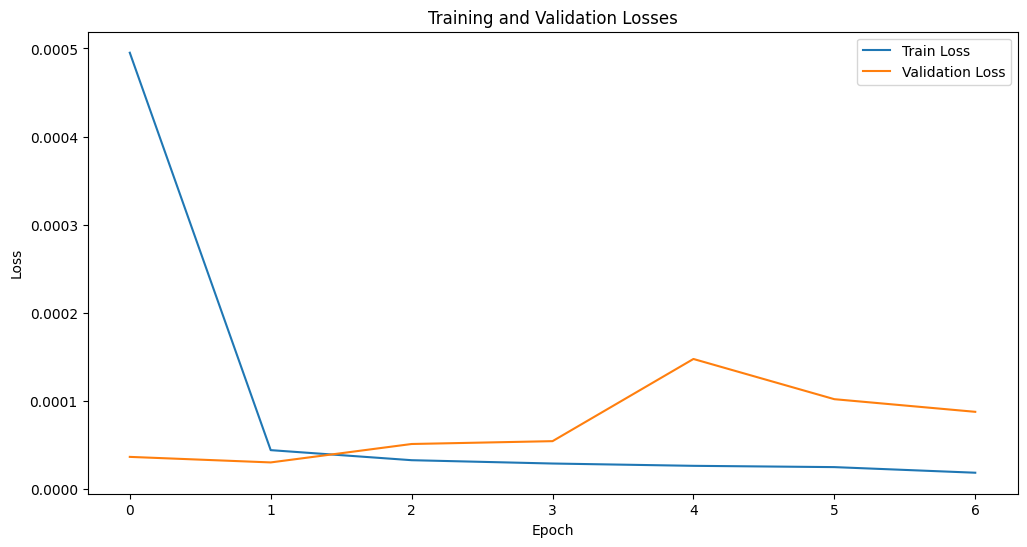

2025-06-05 19:55:56,124 - INFO - Training configuration saved to training_config.json
2025-06-05 19:55:56,124 - INFO - Training configuration saved to training_config.json


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datetime import datetime
import logging
import json
import time
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# from your_model_file import BrainInspiredNetV2_Full, BrainInspiredNetV2_NoHormone, BrainInspiredNetV2_NoIndirect, BrainInspiredNetV2_NoTemporal, BrainInspiredNetV2_SimpleFC

model_dict = {
    "Full": BrainInspiredNetV2,  # 你现在的完整模型类
    "NoHormone": BrainInspiredNetV2_NoHormone,
    "NoIndirect": BrainInspiredNetV2_NoIndirect,
    "NoTemporal": BrainInspiredNetV2_NoTemporal,
    "SimpleFC": BrainInspiredNetV2_SimpleFC,
}


# 配置日志记录器
def setup_logger(log_path=None, level=logging.INFO):
    logger = logging.getLogger()
    logger.setLevel(level)
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    if log_path:
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    return logger

# 设置日志路径
log_path = "training.log"
logger = setup_logger(log_path=log_path)

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 你可以通过修改这里的 key 来选择消融模型
selected_model_key = "NoHormone"  # 比如改成 "Full", "NoIndirect" 等




# 加载保存的 X
X = np.load("X.npy")
print("X shape:", X.shape)  # 输出 X 的形状

# 1. 实例化模型
model_class = model_dict[selected_model_key]
model = model_class(input_dim=X.shape[2]).to(device)

# 2. 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3. 定义损失函数
criterion = nn.MSELoss()

# 4. 定义 Trainer 实例
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_epochs=15,
    patience=5,
    lr_scheduler_patience=3,
    lr_scheduler_factor=0.5,
    save_path="best_model.pth",
    log_path=log_path,
    custom_callbacks=[save_intermediate_model],
    use_mask=False,
    save_state_dict=True
)

# 5. 开始训练
start_time = time.time()  # 记录训练开始时间
training_results = trainer.train()
end_time = time.time()  # 记录训练结束时间
training_duration = end_time - start_time  # 计算训练总耗时

# 6. 打印训练结果
logger.info(f"Starting training for model: {selected_model_key}")
start_time = time.time()
training_results = trainer.train()
end_time = time.time()
training_duration = end_time - start_time
logger.info("Training completed.")
logger.info(f"Training duration: {training_duration / 60:.2f} minutes")
logger.info(f"Train losses: {training_results['train_losses']}")
logger.info(f"Validation losses: {training_results['val_losses']}")
logger.info(f"Best epoch: {training_results['best_epoch']}")
logger.info(f"Best validation loss: {training_results['best_loss']}")


# 7. 绘制训练曲线
plt.figure(figsize=(12, 6))
plt.plot(training_results['train_losses'], label='Train Loss')
plt.plot(training_results['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Losses - Model: {selected_model_key}')
plt.legend()
plt.savefig(f'training_curve_{selected_model_key}.png')  # 每个模型保存不同图
plt.show()

# 8. 自动保存运行配置
# 创建一个字典来保存训练过程中的关键配置和结果
config = {
    "model_name": selected_model_key,  # 记录当前消融版本名字
    "input_dim": X.shape[2],  # 输入维度
    "max_epochs": 15,  # 最大训练轮数
    "patience": 5,  # 早停机制的耐心值
    "lr_scheduler_patience": 3,  # 学习率调度器的耐心值
    "lr_scheduler_factor": 0.5,  # 学习率调度器的衰减因子
    "batch_size": 8,  # 训练数据的批次大小
    "learning_rate": optimizer.param_groups[0]['lr'],  # 初始学习率
    "device": str(device),  # 训练使用的设备（CPU 或 GPU）
    "training_duration": training_duration,  # 训练总耗时（秒）
    "best_epoch": training_results['best_epoch'],  # 最佳训练轮次
    "best_loss": training_results['best_loss'],  # 最佳验证损失
    "save_path": "best_model.pth",  # 最佳模型保存路径
    "log_path": log_path  # 日志文件路径
}

# 定义保存配置文件的路径
config_path = "training_config.json"

# 将配置字典保存为 JSON 文件
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)  # 使用缩进格式化 JSON 文件

# 记录到日志
logger.info(f"Training configuration saved to {config_path}")

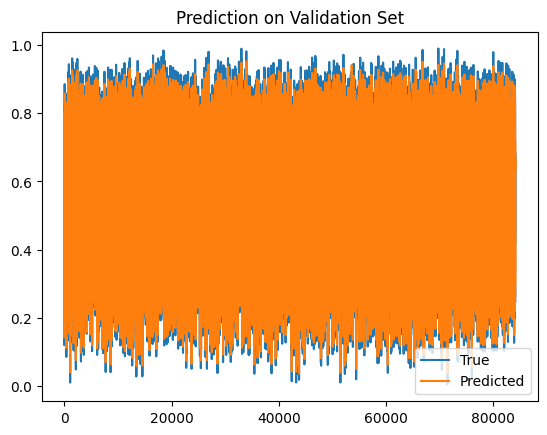

In [13]:
# 将模型设置为评估模式
model.eval()

# 初始化预测值和真实值的列表
preds, actuals = [], []

# 禁用梯度计算（推理阶段不需要计算梯度，节省计算资源和内存）
with torch.no_grad():
    # 遍历验证数据加载器中的每个批次
    for x_batch, y_batch in val_loader:
        # 将输入数据移动到指定设备（CPU或GPU）
        x_batch = x_batch.to(device)
        # 前向传播，获取预测结果（忽略激素状态）
        pred, _ = model(x_batch)
        # 将预测结果从张量转换为 NumPy 数组，并添加到预测值列表中
        preds.extend(pred.cpu().numpy())
        # 将真实值从张量转换为 NumPy 数组，并添加到真实值列表中
        actuals.extend(y_batch.numpy())

# 绘制真实值和预测值的对比图
plt.plot(actuals, label="True")  # 绘制真实值曲线，标签为 "True"
plt.plot(preds, label="Predicted")  # 绘制预测值曲线，标签为 "Predicted"
plt.legend()  # 显示图例
plt.title("Prediction on Validation Set")  # 设置图表标题
plt.show()  # 显示图表

In [14]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actuals, preds)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0001


In [15]:
import numpy as np

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.0094


In [16]:
from sklearn.metrics import r2_score

r2 = r2_score(actuals, preds)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9955


In [17]:
# 导入 sklearn.metrics 中的 mean_squared_error 函数
from sklearn.metrics import mean_squared_error

# 计算均方误差（MSE）
mse = mean_squared_error(actuals, preds)  # 使用 actuals 和 preds 计算 MSE
print(f"Mean Squared Error (MSE): {mse:.4f}")  # 打印 MSE，保留 4 位小数

# 导入 numpy 库
import numpy as np

# 计算均方根误差（RMSE）
rmse = np.sqrt(mse)  # 对 MSE 取平方根得到 RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # 打印 RMSE，保留 4 位小数

# 导入 sklearn.metrics 中的 r2_score 函数
from sklearn.metrics import r2_score

# 计算决定系数（R² Score）
r2 = r2_score(actuals, preds)  # 使用 actuals 和 preds 计算 R² Score
print(f"R² Score: {r2:.4f}")  # 打印 R² Score，保留 4 位小数

Mean Squared Error (MSE): 0.0001
Root Mean Squared Error (RMSE): 0.0094
R² Score: 0.9955


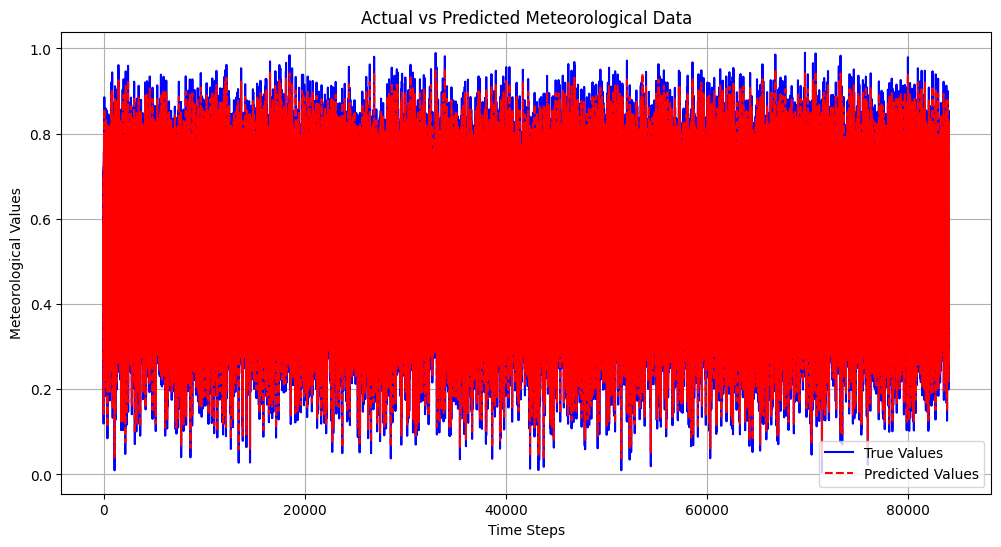

In [18]:
# 绘制实际值与预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="True Values", color="blue")
plt.plot(preds, label="Predicted Values", color="red", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Meteorological Values")
plt.title("Actual vs Predicted Meteorological Data")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== 1. 加载模型 ==========
model = BrainInspiredNetV2(input_dim=X.shape[2]).to(device)
model.load_state_dict(torch.load("best_model_20250605_195543.pth"))
model.eval()

# ========== 2. 加载归一化器 ==========
y_scaler = joblib.load("y_scaler.pkl")

# ========== 3. 定义反归一化函数 ==========
def inverse_transform_target(scaler, data):
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).flatten()

# ========== 4. 验证模型 ==========
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        all_preds.append(outputs.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# ========== 5. 反归一化 ==========
y_pred_inv = inverse_transform_target(y_scaler, all_preds)
y_true_inv = inverse_transform_target(y_scaler, all_targets)

# ========== 6. 计算指标 ==========
rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

print("【反归一化后验证集评估】")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")




【反归一化后验证集评估】
RMSE: 0.5642
MAE : 0.4078
R²  : 0.9955


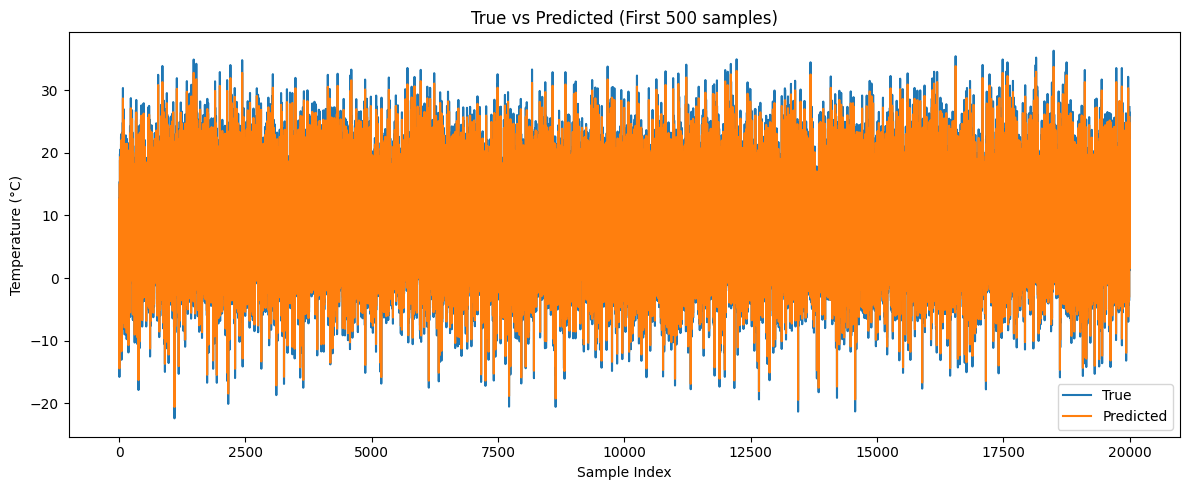

In [25]:
# ========== 7. 可视化预测效果 ==========
plt.figure(figsize=(12, 5))
plt.plot(y_true_inv[:20000], label="True")
plt.plot(y_pred_inv[:20000], label="Predicted")
plt.title("True vs Predicted (First 500 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.savefig("prediction_vs_true.png")
plt.show()